마켓켑과 볼륨이 얼마나 상관성이 높을지?

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess

In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [3]:
start_from = '2020-01'
mktcap = data_pp.mktcap_df.loc[start_from:]
vol = data_pp.vol_df.loc[start_from:]
mask = data_pp.mask.loc[start_from:]

In [139]:
mktcap_res = mktcap.resample('W').mean()
vol_res = vol.resample('W').mean()

m = mktcap_res.melt()
v = vol_res.melt()

concat_df = pd.concat([m,v], axis=1).iloc[:,[0,1,3]].replace(0, np.nan).dropna()
concat_df.columns = ['id', 'mktcap', 'vol']
concat_df

,id,mktcap,vol
0,1,1.318851e+11,2.112971e+10
1,1,1.459596e+11,2.641447e+10
2,1,1.585022e+11,3.452411e+10
3,1,1.555535e+11,2.358766e+10
4,1,1.693888e+11,3.032834e+10
...,...,...,...
1802899,9989,2.379204e+06,1.563699e+04
1802900,9989,2.260723e+06,1.405973e+04
1802901,9989,1.812597e+06,1.589451e+04
1802902,9989,1.415924e+06,1.389600e+04


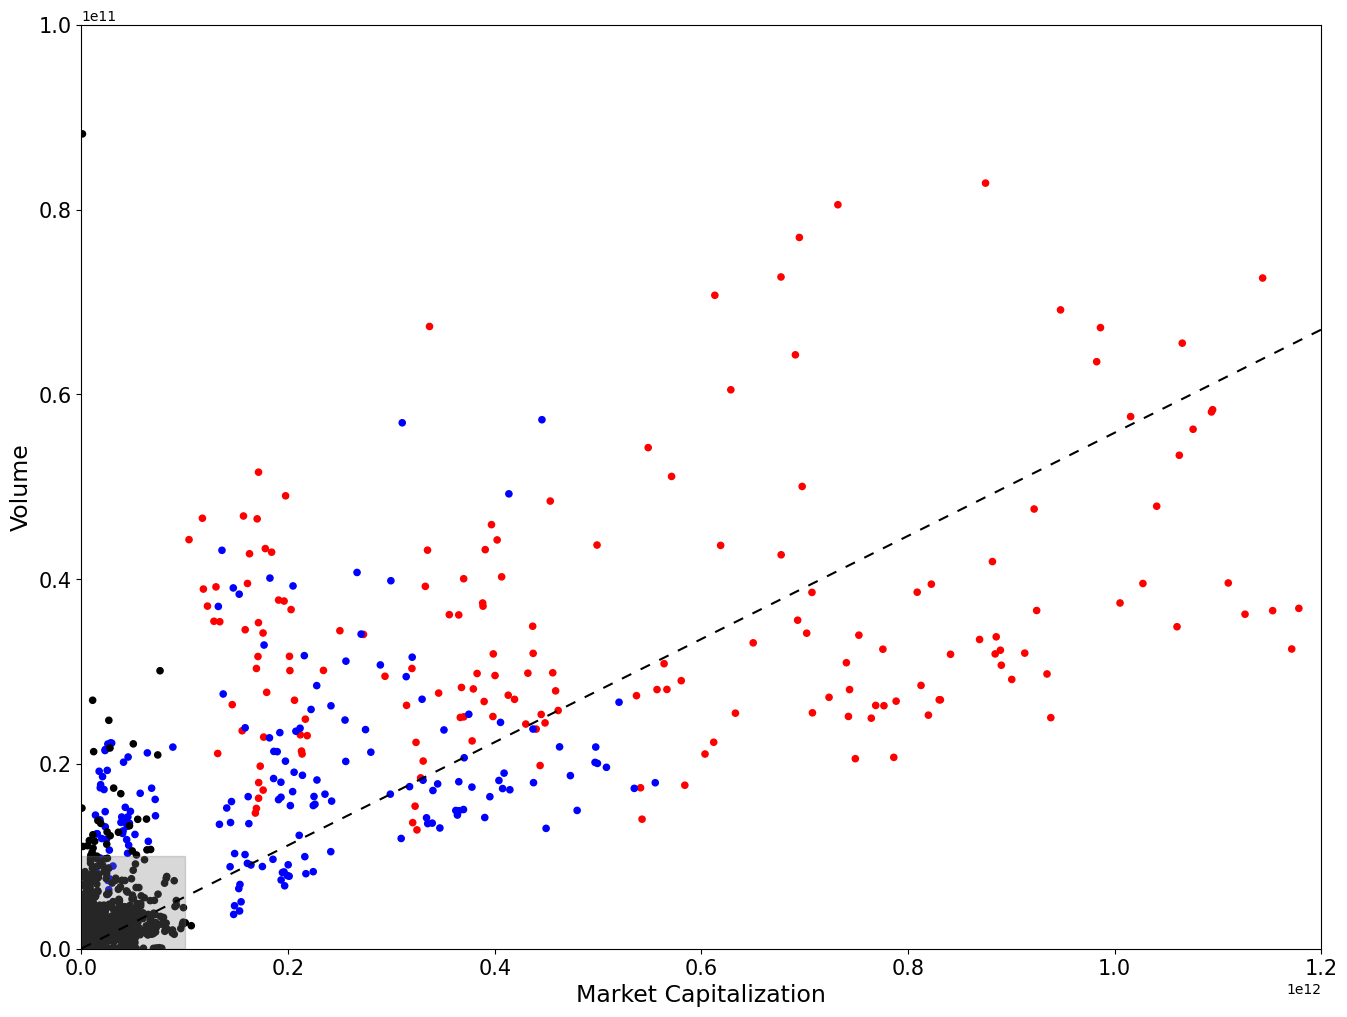

In [160]:
from matplotlib.patches import Rectangle

# Assuming you already have 'concat_df' defined in your environment

# 빨강은 BTC, 파랑은 이더리움
colors = ['red' if i == '1' else ('blue' if i == '1027' else 'black') for i in concat_df['id']]

concat_df.plot(kind='scatter', 
               x='mktcap',
               y='vol',
               figsize=(16,12),
               fontsize=15,
               alpha=1,
               c=colors)

# Fit a linear regression model to the data
m, b = np.polyfit(concat_df['mktcap'], concat_df['vol'], 1)

x = np.linspace(concat_df['mktcap'].min(), concat_df['mktcap'].max(), 100)
y = m * x + b

plt.plot(x, y, c='k', ls='--', dashes=[5, 5])
plt.xlabel('Market Capitalization', fontsize=17)
plt.ylabel('Volume', fontsize=17)
plt.xlim(-1e5, 1e12+2e11)
plt.ylim(-1e5, 1e11)

vline_val = 1e12*0.10
hline_val = 1e11*0.10

# Adding rectangle using the boundaries
rect = Rectangle((0, 0), vline_val, hline_val, facecolor='grey', edgecolor='grey', linestyle='-', alpha=0.3)
plt.gca().add_patch(rect);

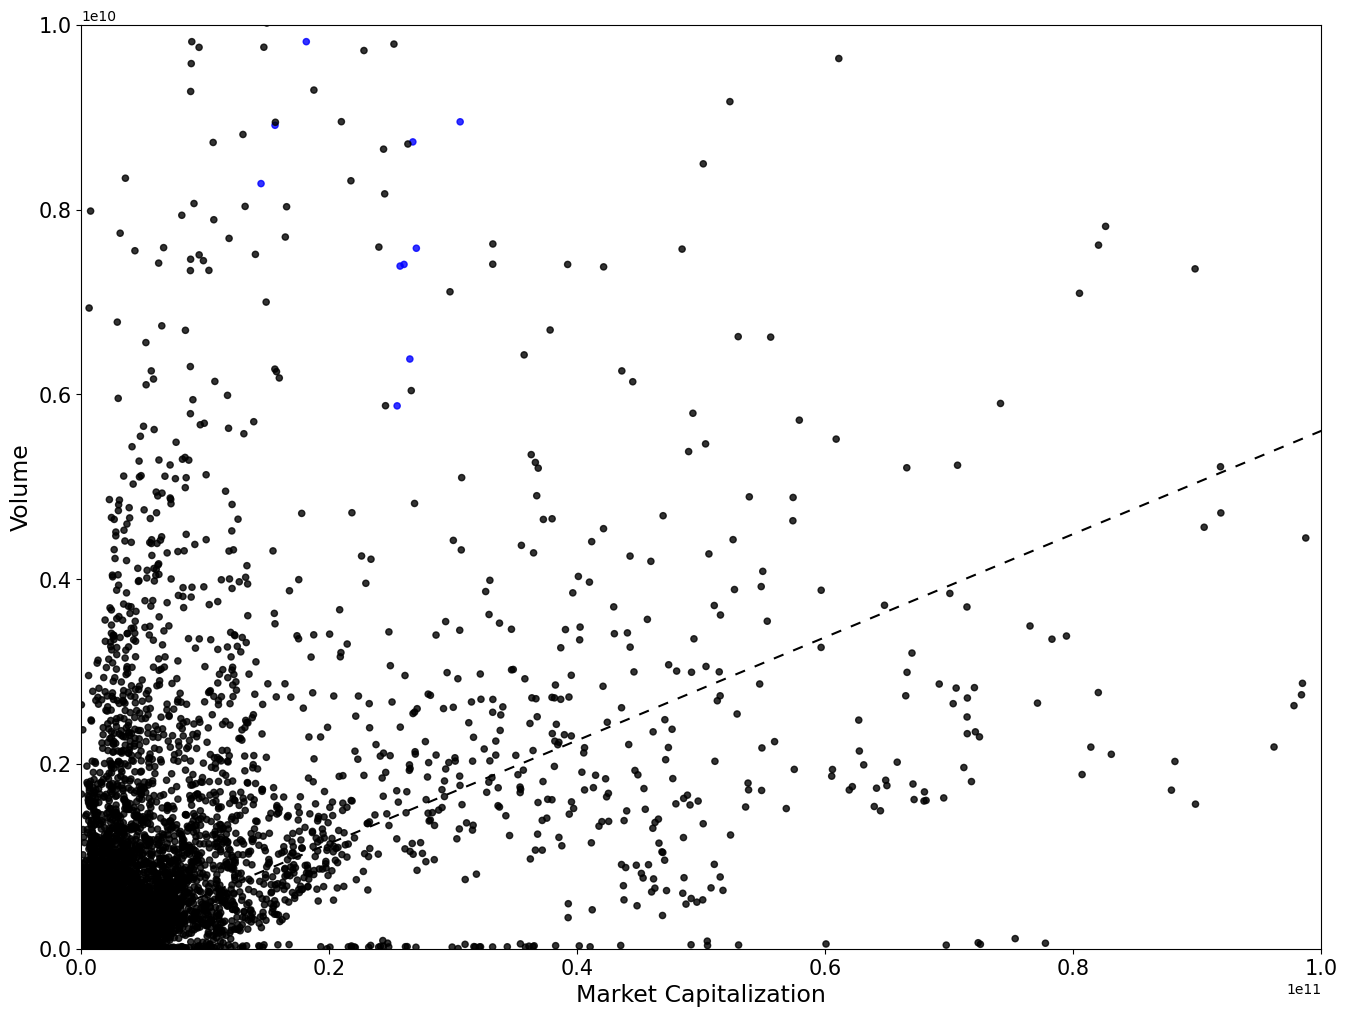

In [161]:
# 빨강은 BTC, 파랑은 이더리움
colors = ['red' if i == '1' else ('blue' if i == '1027' else 'black') for i in concat_df['id']]

concat_df.plot(kind='scatter', 
               x='mktcap',
               y='vol',
               figsize=(16,12),
               fontsize=15,
               alpha=0.8,
               c=colors)

# Fit a linear regression model to the data
m, b = np.polyfit(concat_df['mktcap'], concat_df['vol'], 1)

x = np.linspace(concat_df['mktcap'].min(), concat_df['mktcap'].max(), 100)
y = m * x + b

plt.plot(x, y, c='k', ls='--', dashes=[5, 5])
plt.xlabel('Market Capitalization', fontsize=17)
plt.ylabel('Volume', fontsize=17)

plt.xlim(0,(1e12*0.10))
plt.ylim(0,(1e11*0.1));

In [162]:
exclude_major = concat_df.loc[~concat_df.id.isin(['1', '1027'])]

In [163]:
mask1 = exclude_major.vol < 3_000_000
mask2 = exclude_major.mktcap > 1_000_000_00

mask = mask1 * mask2

exclude_major.loc[mask].id.value_counts().iloc[:20] # 3085: INO / 2499: CHSB / 291: MAID
coin = '291'

v_ = data_pp.vol_df.loc[:, [coin]]
m_ = data_pp.mktcap_df.loc[:, [coin]]

#pd.concat([v_,m_], axis=1, keys=['vol', 'mktcap']).dropna().plot()

In [164]:
import statsmodels.api as sm 

ols = sm.OLS(concat_df.vol, sm.add_constant(concat_df.mktcap))
result = ols.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
=============================================================================
Model:                 OLS                Adj. R-squared:       0.677        
Dependent Variable:    vol                AIC:                  12263743.6763
Date:                  2023-08-26 17:29   BIC:                  12263764.7804
No. Observations:      282677             Log-Likelihood:       -6.1319e+06  
Df Model:              1                  F-statistic:          5.921e+05    
Df Residuals:          282675             Prob (F-statistic):   0.00         
R-squared:             0.677              Scale:                4.0652e+17   
-----------------------------------------------------------------------------
           Coef.       Std.Err.      t     P>|t|      [0.025        0.975]   
-----------------------------------------------------------------------------
const  22708160.6063 1200195.3306  18.9204 0.0000 20355810.9115 25060510.3012
mktcap        0.0558       0.0001 769.4731 0.0000        0.0557        0.0560
-----------------------------------------------------------------------------
Omnibus:              783637.818      Durbin-Watson:         0.405           
Prob(Omnibus):        0.000           Jarque-Bera (JB):      109478152194.894
Skew:                 35.030          Prob(JB):              0.000           
Kurtosis:             3050.961        Condition No.:         16556514174     
=============================================================================
* The condition number is large (2e+10). This might indicate
strong multicollinearity or other numerical problems.
"""

In [165]:
import statsmodels.api as sm 

ols = sm.OLS(exclude_major.vol, sm.add_constant(exclude_major.mktcap))
result = ols.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Ordinary least squares
===========================================================================
Model:                 OLS               Adj. R-squared:      0.225        
Dependent Variable:    vol               AIC:                 11795977.7613
Date:                  2023-08-26 17:29  BIC:                 11795998.8630
No. Observations:      282333            Log-Likelihood:      -5.8980e+06  
Df Model:              1                 F-statistic:         8.187e+04    
Df Residuals:          282331            Prob (F-statistic):  0.00         
R-squared:             0.225             Scale:               8.1754e+16   
---------------------------------------------------------------------------
           Coef.       Std.Err.     t     P>|t|     [0.025        0.975]   
---------------------------------------------------------------------------
const  10960121.2530 541198.8910  20.2516 0.0000 9899386.3708 12020856.1352
mktcap        0.0745      0.0003 286.1266 0.0000       0.0740        0.0750
---------------------------------------------------------------------------
Omnibus:           1198309.928     Durbin-Watson:        0.993             
Prob(Omnibus):     0.000           Jarque-Bera (JB):     12862049611185.361
Skew:              123.169         Prob(JB):             0.000             
Kurtosis:          33067.947       Condition No.:        2089430956        
===========================================================================
* The condition number is large (2e+09). This might indicate
strong multicollinearity or other numerical problems.
"""

마켓켑이 1M 언저리, 볼륨 낮은 애들 찾아보기

In [ ]:
exclude_major.sort_values(by='mktcap').iloc[-10:]